In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, average_precision_score,
                            confusion_matrix, classification_report, roc_curve,
                            precision_recall_curve)
from sklearn.preprocessing import LabelEncoder

2025-11-10 15:34:04.881430: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762788845.048628      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762788845.093092      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU Available: {gpus}")

# Force GPU usage
if gpus:
    try:
        # Enable memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        # Set GPU as default device
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"Using GPU: {len(gpus)} Physical, {len(logical_gpus)} Logical")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("⚠️ No GPU found, using CPU")

# Verify GPU will be used for operations
print(f"\nDevice placement enabled: {tf.config.get_soft_device_placement()}")
tf.config.set_soft_device_placement(True)
print("✓ Soft device placement enabled")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Using GPU: 2 Physical, 1 Logical

Device placement enabled: True
✓ Soft device placement enabled


I0000 00:00:1762788855.870478      39 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


In [3]:
# ============================================================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================================================

class LegalClauseDataLoader:
    """Load and prepare legal clause dataset"""
    
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.df = None
        self.clause_types = []
        
    def load_data(self):
        """Load all CSV files from directory"""
        csv_files = list(self.data_path.glob('*.csv'))
        print(f"Found {len(csv_files)} CSV files")
        
        all_data = []
        for file in csv_files:
            try:
                df_temp = pd.read_csv(file)
                # Extract category from filename
                category = file.stem
                df_temp['category'] = category
                all_data.append(df_temp)
                print(f"Loaded {file.name}: {len(df_temp)} clauses")
            except Exception as e:
                print(f"Error loading {file.name}: {e}")
        
        self.df = pd.concat(all_data, ignore_index=True)
        print(f"\nTotal clauses loaded: {len(self.df)}")
        return self.df
    
    def preprocess_text(self, text):
        """Clean and preprocess legal text"""
        if pd.isna(text):
            return ""
        
        text = str(text).lower()
        # Remove special characters but keep legal punctuation
        text = re.sub(r'[^a-zA-Z0-9\s\.,;:\-\(\)]', '', text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def create_pairs(self, strategy='balanced', max_pairs_per_type=1000):
        """
        Create clause pairs for similarity learning - OPTIMIZED VERSION
        
        Strategy options:
        - 'balanced': Equal positive (same type) and negative (different type) pairs
        
        Args:
            max_pairs_per_type: Maximum positive pairs per clause type (default: 1000)
        """
        print("Creating pairs (optimized)...")
        pairs = []
        labels = []
        
        # Group by clause type
        grouped = self.df.groupby('clause_type')
        clause_types = list(grouped.groups.keys())
        
        print(f"Found {len(clause_types)} unique clause types")
        
        # Positive pairs (same type) - OPTIMIZED
        for idx, (clause_type, group) in enumerate(grouped):
            clauses = group['clause_text'].values
            n = len(clauses)
            
            if n < 2:
                continue
            
            # Limit pairs to avoid memory issues
            num_pairs = min(max_pairs_per_type, n * (n-1) // 2)
            
            # Random sampling instead of nested loops
            if num_pairs < n * (n-1) // 2:
                # Sample random indices
                idx1 = np.random.randint(0, n, size=num_pairs)
                idx2 = np.random.randint(0, n, size=num_pairs)
                
                # Ensure idx1 != idx2
                mask = idx1 != idx2
                idx1 = idx1[mask][:num_pairs]
                idx2 = idx2[mask][:num_pairs]
                
                for i, j in zip(idx1, idx2):
                    pairs.append((clauses[i], clauses[j]))
                    labels.append(1)
            else:
                # Small group, use all combinations
                for i in range(n):
                    for j in range(i+1, n):
                        pairs.append((clauses[i], clauses[j]))
                        labels.append(1)
            
            if (idx + 1) % 10 == 0:
                print(f"  Processed {idx + 1}/{len(clause_types)} types, {len(pairs)} pairs so far")
        
        num_positive = len(labels)
        print(f"✓ Created {num_positive} positive pairs")
        
        # Negative pairs (different types) - VECTORIZED
        print("Creating negative pairs...")
        num_negative = num_positive
        
        # Pre-create arrays for vectorized sampling
        type_idx1 = np.random.randint(0, len(clause_types), size=num_negative)
        type_idx2 = np.random.randint(0, len(clause_types), size=num_negative)
        
        # Ensure different types
        mask = type_idx1 != type_idx2
        while not mask.all():
            type_idx2[~mask] = np.random.randint(0, len(clause_types), size=(~mask).sum())
            mask = type_idx1 != type_idx2
        
        # Batch create negative pairs
        for i in range(num_negative):
            type1 = clause_types[type_idx1[i]]
            type2 = clause_types[type_idx2[i]]
            
            clause1 = np.random.choice(grouped.get_group(type1)['clause_text'].values)
            clause2 = np.random.choice(grouped.get_group(type2)['clause_text'].values)
            
            pairs.append((clause1, clause2))
            labels.append(0)
            
            if (i + 1) % 5000 == 0:
                print(f"  Created {i + 1}/{num_negative} negative pairs")
        
        print(f"✓ Created {num_negative} negative pairs")
        print(f"✓ Total pairs: {len(labels)} (balanced)")
        
        return pairs, np.array(labels)

In [4]:
# ============================================================================
# 2. TEXT VECTORIZATION
# ============================================================================

class TextVectorizer:
    """Convert text to sequences for neural networks"""
    
    def __init__(self, max_words=10000, max_len=200):
        self.max_words = max_words
        self.max_len = max_len
        self.tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
        
    def fit_transform(self, texts):
        """Fit tokenizer and transform texts"""
        self.tokenizer.fit_on_texts(texts)
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post')
        
        print(f"Vocabulary size: {len(self.tokenizer.word_index)}")
        print(f"Sequence length: {self.max_len}")
        
        return padded
    
    def transform(self, texts):
        """Transform new texts"""
        sequences = self.tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(sequences, maxlen=self.max_len, padding='post')
        return padded

In [5]:
# ============================================================================
# 3. MODEL ARCHITECTURES
# ============================================================================

class BiLSTMAttentionModel:
    """
    Baseline 1: BiLSTM with Attention Mechanism
    
    Architecture:
    - Embedding Layer
    - Bidirectional LSTM
    - Custom Attention Layer
    - Dense layers for similarity scoring
    """
    
    def __init__(self, vocab_size, embedding_dim=128, lstm_units=64, max_len=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.max_len = max_len
        self.model = None
        
    def attention_layer(self, inputs):
        """Custom attention mechanism"""
        # inputs shape: (batch, timesteps, features)
        attention_weights = layers.Dense(1, activation='tanh')(inputs)
        attention_weights = layers.Flatten()(attention_weights)
        attention_weights = layers.Activation('softmax')(attention_weights)
        attention_weights = layers.RepeatVector(self.lstm_units * 2)(attention_weights)
        attention_weights = layers.Permute([2, 1])(attention_weights)
        
        weighted = layers.Multiply()([inputs, attention_weights])
        output = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1))(weighted)
        
        return output
    
    def build_model(self):
        """Build Siamese BiLSTM with Attention"""
        
        # Shared embedding layer
        embedding = layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_len,
            mask_zero=True
        )
        
        # Shared BiLSTM
        bilstm = layers.Bidirectional(
            layers.LSTM(self.lstm_units, return_sequences=True, dropout=0.3)
        )
        
        # Input branches
        input_1 = layers.Input(shape=(self.max_len,), name='clause_1')
        input_2 = layers.Input(shape=(self.max_len,), name='clause_2')
        
        # Shared encoding pipeline
        def encode_clause(input_tensor):
            x = embedding(input_tensor)
            x = bilstm(x)
            x = self.attention_layer(x)
            x = layers.Dropout(0.3)(x)
            return x
        
        encoded_1 = encode_clause(input_1)
        encoded_2 = encode_clause(input_2)
        
        # Compute similarity features
        # L1 distance
        l1_distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_1, encoded_2])
        # Element-wise multiplication
        multiply = layers.Multiply()([encoded_1, encoded_2])
        # Concatenation
        concat = layers.Concatenate()([encoded_1, encoded_2, l1_distance, multiply])
        
        # Classification head
        x = layers.Dense(128, activation='relu')(concat)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        output = layers.Dense(1, activation='sigmoid', name='similarity')(x)
        
        self.model = Model(inputs=[input_1, input_2], outputs=output)
        
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc'), 
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall')]
        )
        
        return self.model
    
    def summary(self):
        """Display model architecture"""
        if self.model:
            return self.model.summary()

class CNNBiGRUModel:
    """
    Baseline 2: CNN-BiGRU Hybrid
    
    Architecture:
    - Embedding Layer
    - 1D Convolutional layers (multiple filter sizes)
    - Bidirectional GRU
    - Global pooling
    - Dense layers for similarity scoring
    """
    
    def __init__(self, vocab_size, embedding_dim=128, max_len=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_len = max_len
        self.model = None
        
    def build_model(self):
        """Build Siamese CNN-BiGRU"""
        
        # Shared layers
        embedding = layers.Embedding(
            input_dim=self.vocab_size,
            output_dim=self.embedding_dim,
            input_length=self.max_len
        )
        
        # Multi-scale CNN
        def cnn_block(x, filters, kernel_size):
            conv = layers.Conv1D(filters, kernel_size, activation='relu', padding='same')(x)
            conv = layers.BatchNormalization()(conv)
            pool = layers.MaxPooling1D(2)(conv)
            return pool
        
        # BiGRU
        bigru = layers.Bidirectional(layers.GRU(64, return_sequences=True, dropout=0.3))
        
        # Inputs
        input_1 = layers.Input(shape=(self.max_len,), name='clause_1')
        input_2 = layers.Input(shape=(self.max_len,), name='clause_2')
        
        # Shared encoding
        def encode_clause(input_tensor):
            x = embedding(input_tensor)
            
            # Parallel CNN branches with different kernel sizes
            conv1 = cnn_block(x, 64, 3)
            conv2 = cnn_block(x, 64, 5)
            conv3 = cnn_block(x, 64, 7)
            
            # Concatenate CNN outputs
            x = layers.Concatenate()([conv1, conv2, conv3])
            
            # BiGRU
            x = bigru(x)
            
            # Global pooling
            avg_pool = layers.GlobalAveragePooling1D()(x)
            max_pool = layers.GlobalMaxPooling1D()(x)
            x = layers.Concatenate()([avg_pool, max_pool])
            
            x = layers.Dropout(0.4)(x)
            return x
        
        encoded_1 = encode_clause(input_1)
        encoded_2 = encode_clause(input_2)
        
        # Similarity computation
        l1_distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded_1, encoded_2])
        multiply = layers.Multiply()([encoded_1, encoded_2])
        concat = layers.Concatenate()([encoded_1, encoded_2, l1_distance, multiply])
        
        # Classification head
        x = layers.Dense(128, activation='relu')(concat)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        output = layers.Dense(1, activation='sigmoid', name='similarity')(x)
        
        self.model = Model(inputs=[input_1, input_2], outputs=output)
        
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', keras.metrics.AUC(name='auc'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall')]
        )
        
        return self.model
    
    def summary(self):
        """Display model architecture"""
        if self.model:
            return self.model.summary()

In [6]:
# ============================================================================
# 4. EVALUATION
# ============================================================================

class ModelEvaluator:
    """Comprehensive model evaluation and visualization"""
    
    @staticmethod
    def evaluate_model(model, X_test, y_test, model_name="Model"):
        """Calculate all evaluation metrics"""
        
        # Predictions
        y_pred_proba = model.predict([X_test[0], X_test[1]], verbose=0).flatten()
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        # Metrics
        metrics = {
            'Model': model_name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, zero_division=0),
            'Recall': recall_score(y_test, y_pred, zero_division=0),
            'F1-Score': f1_score(y_test, y_pred, zero_division=0),
            'ROC-AUC': roc_auc_score(y_test, y_pred_proba),
            'PR-AUC': average_precision_score(y_test, y_pred_proba)
        }
        
        return metrics, y_pred, y_pred_proba
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, model_name):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Dissimilar', 'Similar'],
                   yticklabels=['Dissimilar', 'Similar'])
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_roc_curve(y_true, y_pred_proba, model_name):
        """Plot ROC curve"""
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        auc_score = roc_auc_score(y_true, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', linewidth=2)
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_pr_curve(y_true, y_pred_proba, model_name):
        """Plot Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = average_precision_score(y_true, y_pred_proba)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'{model_name} (PR-AUC = {pr_auc:.4f})', linewidth=2)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_training_history(history, model_name):
        """Plot training history"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        axes[0, 0].plot(history.history['loss'], label='Train Loss')
        axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
        axes[0, 0].set_title(f'{model_name} - Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(alpha=0.3)
        
        # Accuracy
        axes[0, 1].plot(history.history['accuracy'], label='Train Acc')
        axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc')
        axes[0, 1].set_title(f'{model_name} - Accuracy')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(alpha=0.3)
        
        # AUC
        axes[1, 0].plot(history.history['auc'], label='Train AUC')
        axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
        axes[1, 0].set_title(f'{model_name} - AUC')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(alpha=0.3)
        
        # F1-Score (Precision & Recall)
        axes[1, 1].plot(history.history['precision'], label='Train Precision')
        axes[1, 1].plot(history.history['val_precision'], label='Val Precision')
        axes[1, 1].plot(history.history['recall'], label='Train Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
        axes[1, 1].set_title(f'{model_name} - Precision & Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Score')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [ ]:
# ============================================================================
# 5. MAIN EXECUTION PIPELINE
# ============================================================================
print("="*80)
print("LEGAL CLAUSE SIMILARITY DETECTION - BASELINE MODELS")
print("="*80)

# ========== DATA LOADING ==========
print("\n[1/7] Loading Data")
data_path = '/kaggle/input/legalclausedataset' 
loader = LegalClauseDataLoader(data_path)
df = loader.load_data()

LEGAL CLAUSE SIMILARITY DETECTION - BASELINE MODELS

[1/7] Loading Data
Found 395 CSV files
Loaded certain-definitions.csv: 520 clauses
Loaded proprietary_rights.csv: 310 clauses
Loaded limitation-of-liability.csv: 320 clauses
Loaded severability-of-provisions.csv: 440 clauses
Loaded other-agreements.csv: 420 clauses
Loaded representations.csv: 400 clauses
Loaded payment-terms.csv: 370 clauses
Loaded definitions.csv: 560 clauses
Loaded effectiveness.csv: 480 clauses
Loaded additional-documents.csv: 470 clauses
Loaded no-assignment.csv: 480 clauses
Loaded benefits.csv: 410 clauses
Loaded vesting.csv: 400 clauses
Loaded construction.csv: 410 clauses
Loaded time-of-the-essence.csv: 620 clauses
Loaded entire-agreement.csv: 440 clauses
Loaded execution.csv: 460 clauses
Loaded material-contracts.csv: 330 clauses
Loaded cooperation.csv: 350 clauses
Loaded compliance.csv: 350 clauses
Loaded transfer.csv: 390 clauses
Loaded security.csv: 380 clauses
Loaded holidays.csv: 430 clauses
Loaded sever

In [8]:
# Preprocess
print("\n[2/7] Preprocessing Text")
df['clause_text'] = df['clause_text'].apply(loader.preprocess_text)

In [9]:
# Create pairs
print("\n[3/7] Creating Clause Pairs")
pairs, labels = loader.create_pairs(strategy='balanced', max_pairs_per_type=1000)


[3/7] Creating Clause Pairs
Creating pairs (optimized)...
Found 395 unique clause types
  Processed 10/395 types, 9979 pairs so far
  Processed 20/395 types, 19948 pairs so far
  Processed 30/395 types, 29914 pairs so far
  Processed 40/395 types, 39880 pairs so far
  Processed 50/395 types, 49860 pairs so far
  Processed 60/395 types, 59834 pairs so far
  Processed 70/395 types, 69802 pairs so far
  Processed 80/395 types, 79770 pairs so far
  Processed 90/395 types, 89742 pairs so far
  Processed 100/395 types, 99713 pairs so far
  Processed 110/395 types, 109687 pairs so far
  Processed 120/395 types, 119650 pairs so far
  Processed 130/395 types, 129621 pairs so far
  Processed 140/395 types, 139591 pairs so far
  Processed 150/395 types, 149559 pairs so far
  Processed 160/395 types, 159528 pairs so far
  Processed 170/395 types, 169489 pairs so far
  Processed 180/395 types, 179470 pairs so far
  Processed 190/395 types, 189445 pairs so far
  Processed 200/395 types, 199427 pair

In [10]:
# ========== VECTORIZATION ==========
print("\n[4/7] Vectorizing Text...")
all_texts = [text for pair in pairs for text in pair]

vectorizer = TextVectorizer(max_words=10000, max_len=200)
print("Fitting tokenizer...")
vectorizer.fit_transform(all_texts)

# Transform pairs
print("Transforming clause pairs...")
clause1_texts = [pair[0] for pair in pairs]
clause2_texts = [pair[1] for pair in pairs]

clause1_seq = vectorizer.transform(clause1_texts)
clause2_seq = vectorizer.transform(clause2_texts)

print("✓ Vectorization complete")

# Train-test split
print("\nSplitting data...")
indices = np.arange(len(labels))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42, stratify=labels)

X1_train, X1_test = clause1_seq[train_idx], clause1_seq[test_idx]
X2_train, X2_test = clause2_seq[train_idx], clause2_seq[test_idx]
y_train, y_test = labels[train_idx], labels[test_idx]

print(f"✓ Training samples: {len(y_train)}, Test samples: {len(y_test)}")
print(f"✓ Data shape: {X1_train.shape}")

# Convert to TensorFlow tensors for GPU processing
print("\nConverting to TensorFlow tensors...")
X1_train = tf.constant(X1_train, dtype=tf.int32)
X2_train = tf.constant(X2_train, dtype=tf.int32)
X1_test = tf.constant(X1_test, dtype=tf.int32)
X2_test = tf.constant(X2_test, dtype=tf.int32)
y_train = tf.constant(y_train, dtype=tf.float32)
y_test = tf.constant(y_test, dtype=tf.float32)
print("✓ Tensors ready for GPU")


[4/7] Vectorizing Text...
Fitting tokenizer...
Vocabulary size: 47560
Sequence length: 200
Transforming clause pairs...
✓ Vectorization complete

Splitting data...
✓ Training samples: 628691, Test samples: 157173
✓ Data shape: (628691, 200)

Converting to TensorFlow tensors...
✓ Tensors ready for GPU


In [11]:
# ========== MODEL TRAINING ==========
vocab_size = min(10000, len(vectorizer.tokenizer.word_index) + 1)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

results = []


[5/7] Training Model 1: BiLSTM with Attention...
--------------------------------------------------------------------------------
Checking device placement...
✓ Test tensor on device: /job:localhost/replica:0/task:0/device:GPU:0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ clause_1            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clause_2            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  1,280,000 │ clause_1[0][0],   │
│ (Embedding)         │                   │            │ clause_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ clause_1[0][0]    │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 200)       │          0 │ clause_2[0][0]    │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 200, 128)  │     98,816 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0],  │
│                     │                   │            │ embedding[1][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 200, 1)    │        129 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 200, 1)    │        129 │ bidirectional[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 200)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 200)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 200)       │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 200)       │          0 │ flatten_1[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 200)  │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 128, 200)  │          0 │ activation_1[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 200, 128)  │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 200, 128)  │          0 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 200, 128)  │          0 │ bidirectional[0]… │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 200, 128)  │          0 │ bidirectional[1]… │
│ (Multiply)          │                   │            │ permute_1[0][0] 

 Total params: 1,453,059 (5.54 MB)

 Trainable params: 1,453,059 (5.54 MB)

 Non-trainable params: 0 (0.00 B)


🚀 Starting training on GPU...
Epoch 1/30


I0000 00:00:1762789228.852594      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


4912/4912 ━━━━━━━━━━━━━━━━━━━━ 292s 56ms/step - accuracy: 0.6219 - auc: 0.6756 - loss: 0.6236 - precision: 0.6057 - recall: 0.6882 - val_accuracy: 0.7720 - val_auc: 0.8884 - val_loss: 0.4669 - val_precision: 0.6934 - val_recall: 0.9751 - learning_rate: 0.0010
Epoch 2/30
4912/4912 ━━━━━━━━━━━━━━━━━━━━ 274s 56ms/step - accuracy: 0.8160 - auc: 0.8917 - loss: 0.4011 - precision: 0.7750 - recall: 0.8910 - val_accuracy: 0.8145 - val_auc: 0.9284 - val_loss: 0.4215 - val_precision: 0.7357 - val_recall: 0.9818 - learning_rate: 0.0010
Epoch 3/30
4912/4912 ━━━━━━━━━━━━━━━━━━━━ 275s 56ms/step - accuracy: 0.8542 - auc: 0.9301 - loss: 0.3278 - precision: 0.8205 - recall: 0.9072 - val_accuracy: 0.8547 - val_auc: 0.9487 - val_loss: 0.3527 - val_precision: 0.7831 - val_recall: 0.9812 - learning_rate: 0.0010
Epoch 4/30
4912/4912 ━━━━━━━━━━━━━━━━━━━━ 275s 56ms/step - accuracy: 0.8748 - auc: 0.9462 - loss: 0.2873 - precision: 0.8435 - recall: 0.9206 - val_accuracy: 0.8584 - val_auc: 0.9562 - val_loss: 0.3

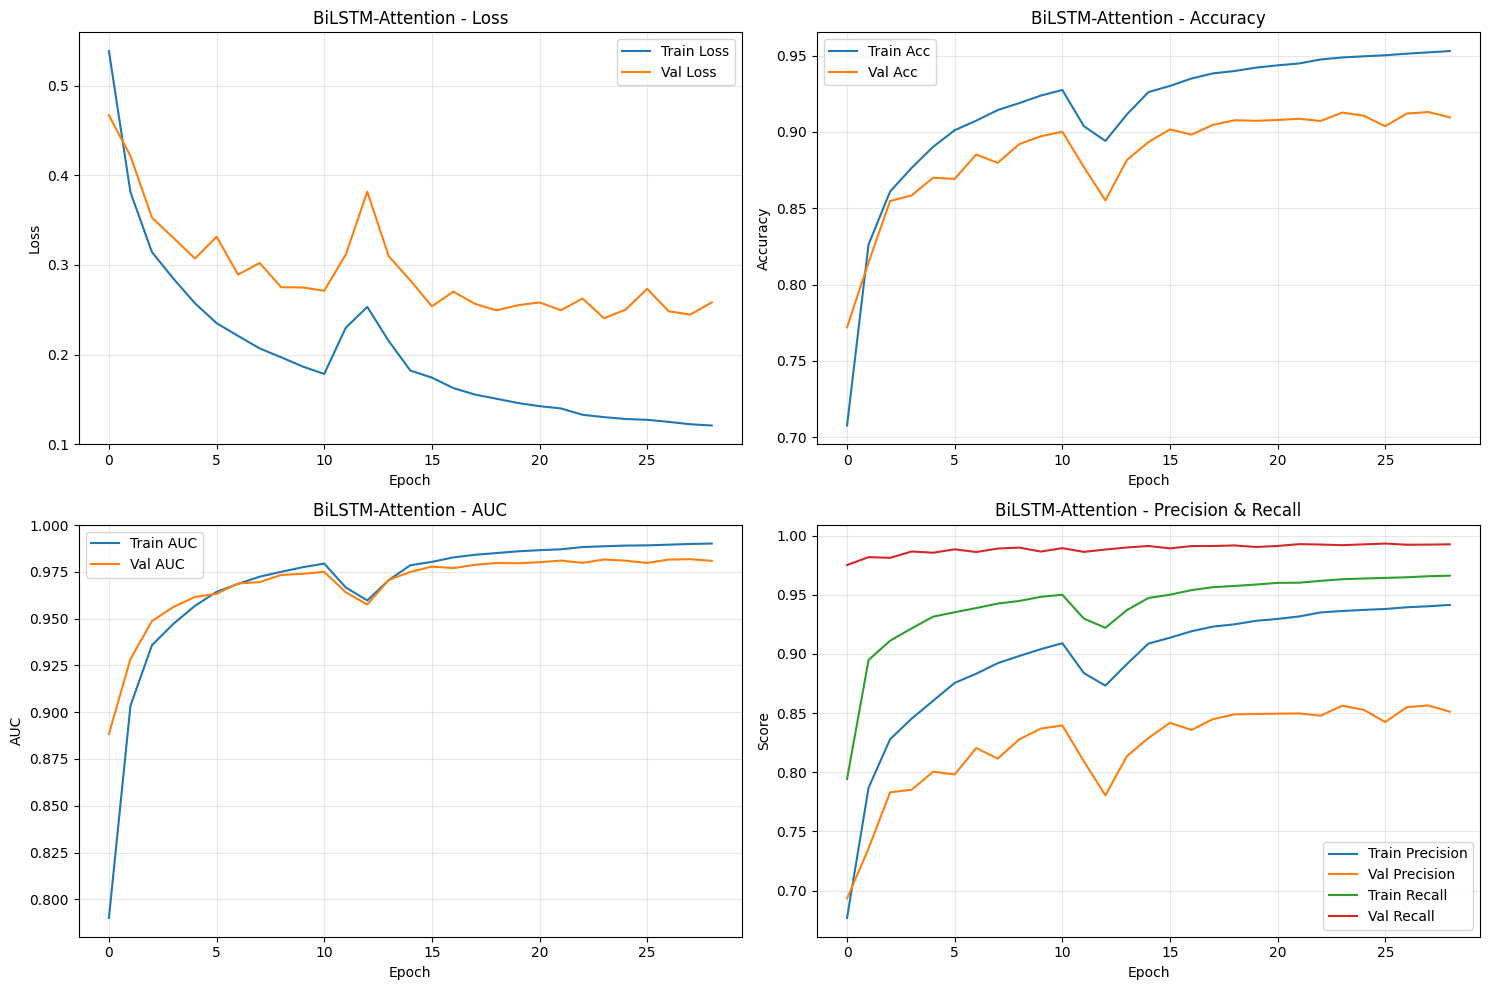

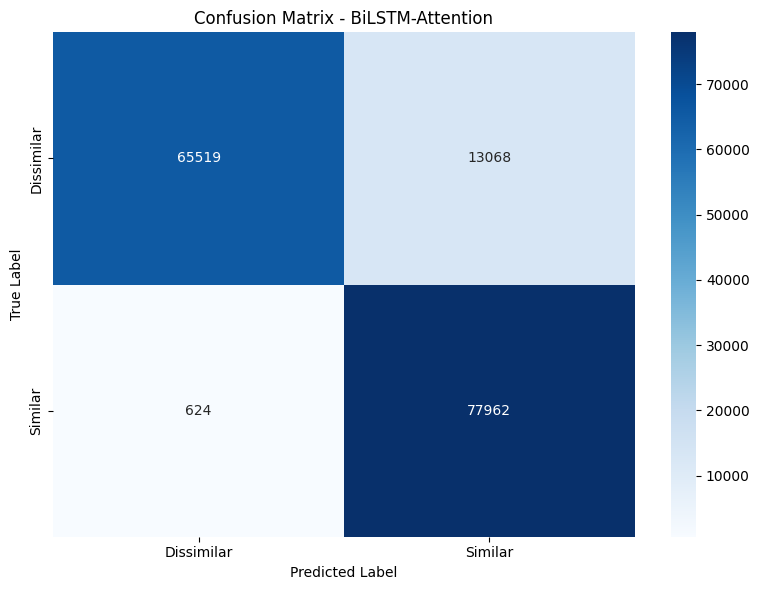

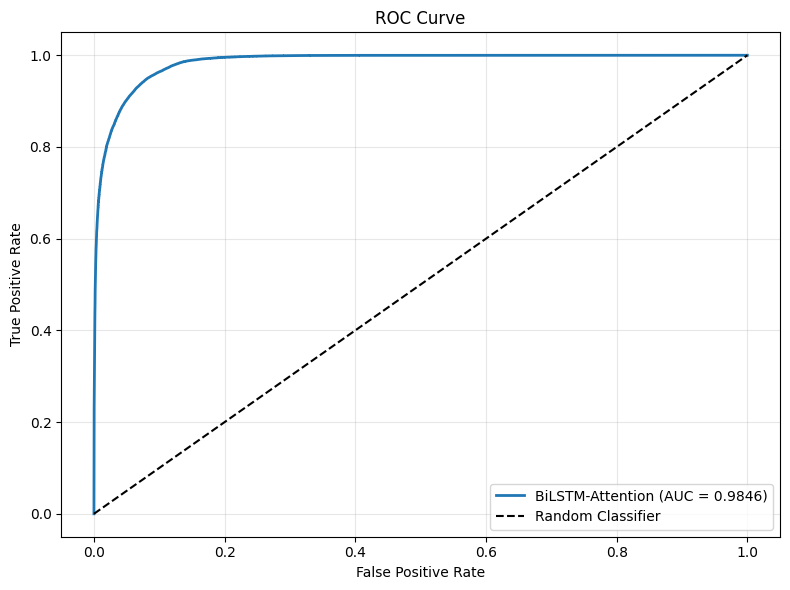

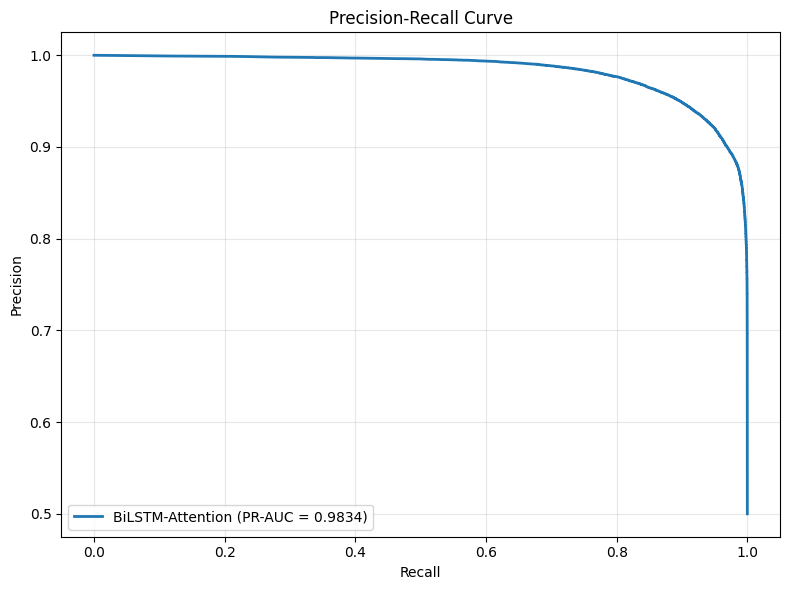

In [12]:
# ========== MODEL 1: BiLSTM with Attention ==========
print("\n[5/7] Training Model 1: BiLSTM with Attention...")
print("-"*80)

# Verify GPU usage
print("Checking device placement...")
with tf.device('/GPU:0'):
    test_tensor = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    print(f"✓ Test tensor on device: {test_tensor.device}")

model1_arch = BiLSTMAttentionModel(vocab_size, embedding_dim=128, lstm_units=64, max_len=200)
model1 = model1_arch.build_model()
model1_arch.summary()

print("\n🚀 Starting training on GPU...")
history1 = model1.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_test, X2_test], y_test),
    epochs=30,
    batch_size=128,  # Increased for GPU
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
print("✓ Model 1 training completed")

# Evaluate
metrics1, y_pred1, y_proba1 = ModelEvaluator.evaluate_model(
    model1, [X1_test, X2_test], y_test, "BiLSTM-Attention"
)
results.append(metrics1)

# Visualizations
ModelEvaluator.plot_training_history(history1, "BiLSTM-Attention")
ModelEvaluator.plot_confusion_matrix(y_test, y_pred1, "BiLSTM-Attention")
ModelEvaluator.plot_roc_curve(y_test, y_proba1, "BiLSTM-Attention")
ModelEvaluator.plot_pr_curve(y_test, y_proba1, "BiLSTM-Attention")


[6/7] Training Model 2: CNN-BiGRU Hybrid...
--------------------------------------------------------------------------------


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ clause_1            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clause_2            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 200, 128)  │  1,280,000 │ clause_1[0][0],   │
│ (Embedding)         │                   │            │ clause_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 200, 64)   │     24,640 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 200, 64)   │     41,024 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 200, 64)   │     57,408 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 200, 64)   │     24,640 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 200, 64)   │     41,024 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 200, 64)   │     57,408 │ embedding_1[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 200, 64)   │        256 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 100, 64)   │          0 │ batch_normalizat

 Total params: 1,766,785 (6.74 MB)

 Trainable params: 1,765,761 (6.74 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/30
4912/4912 ━━━━━━━━━━━━━━━━━━━━ 340s 66ms/step - accuracy: 0.5536 - auc: 0.5808 - loss: 0.6842 - precision: 0.5505 - recall: 0.5745 - val_accuracy: 0.8582 - val_auc: 0.9350 - val_loss: 0.3426 - val_precision: 0.7944 - val_recall: 0.9664 - learning_rate: 0.0010
Epoch 2/30
4912/4912 ━━━━━━━━━━━━━━━━━━━━ 322s 66ms/step - accuracy: 0.8691 - auc: 0.9402 - loss: 0.2940 - precision: 0.8277 - recall: 0.9328 - val_accuracy: 0.8957 - val_auc: 0.9671 - val_loss: 0.2514 - val_precision: 0.8421 - val_recall: 0.9741 - learning_rate: 0.0010
Epoch 3/30
4912/4912 ━━━━━━━━━━━━━━━━━━━━ 322s 66ms/step - accuracy: 0.9018 - auc: 0.9670 - loss: 0.2210 - precision: 0.8680 - recall: 0.9481 - val_accuracy: 0.9093 - val_auc: 0.9743 - val_loss: 0.2169 - val_precision: 0.8606 - val_recall: 0.9769 - learning_rate: 0.0010
Epoch 4/30
4912/4912 ━━━━━━━━━━━━━━━━━━━━ 322s 66ms/step - accuracy: 0.9155 - auc: 0.9753 - loss: 0.1912 - precision: 0.8844 - recall: 0.9562 - val_accuracy: 0.9202 - val_auc: 0.9789 - va

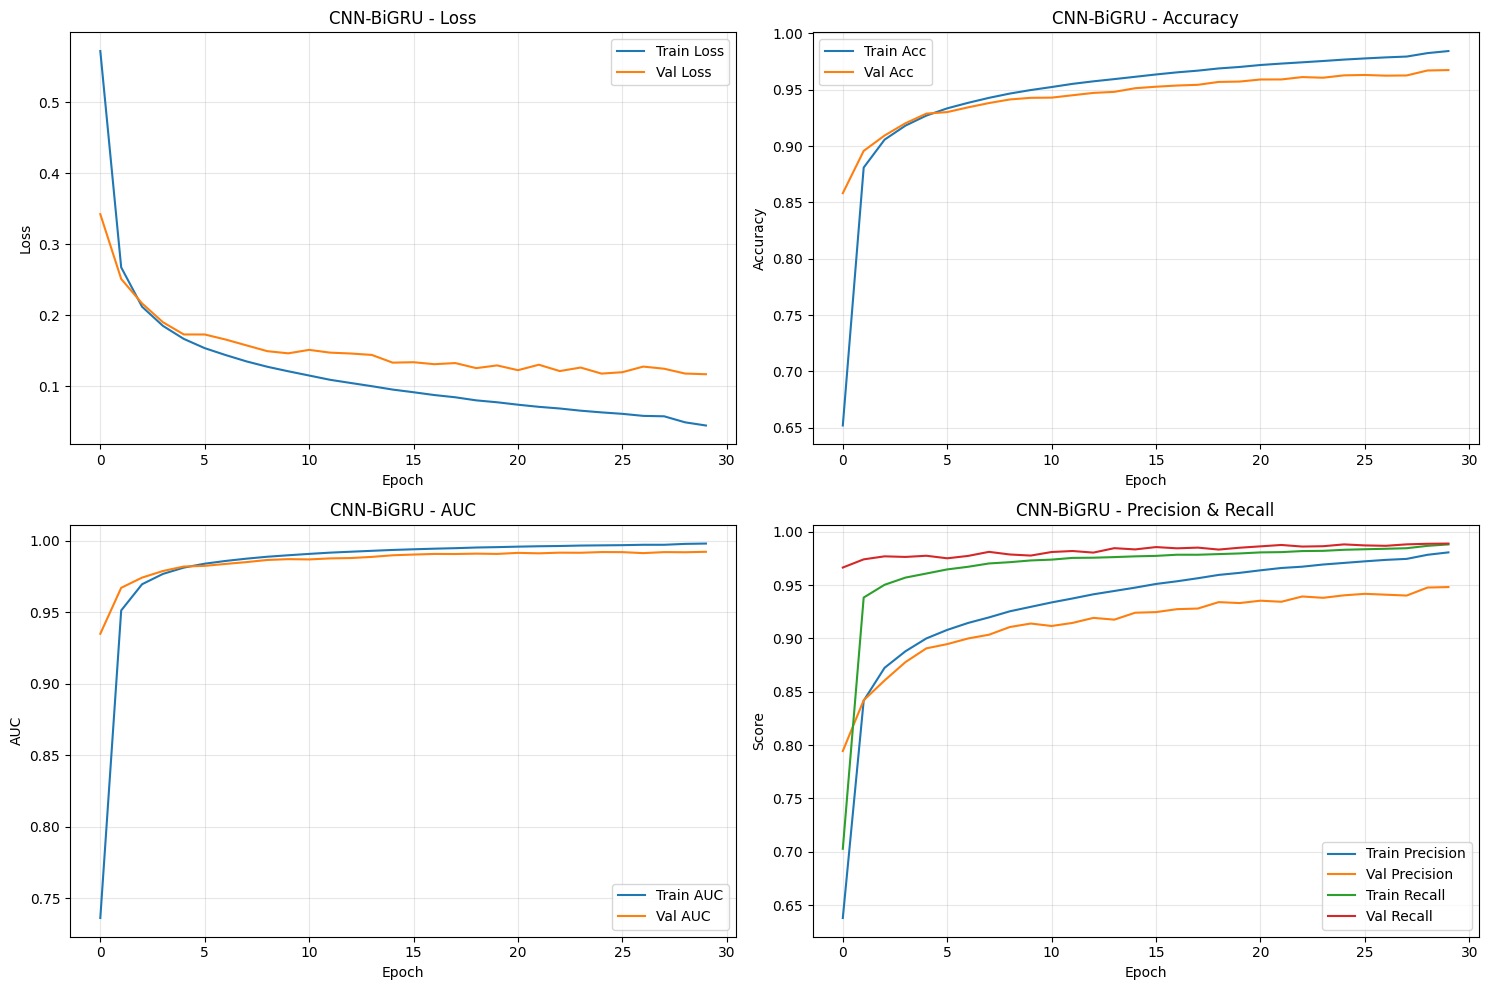

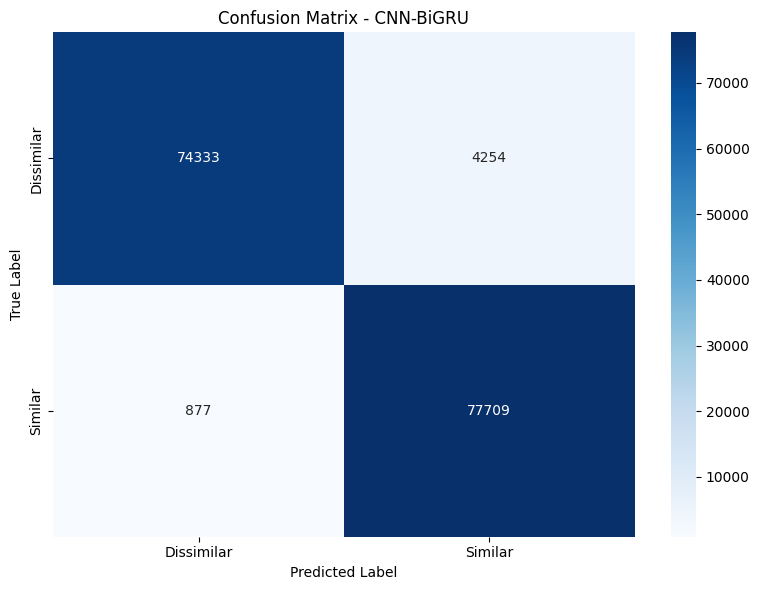

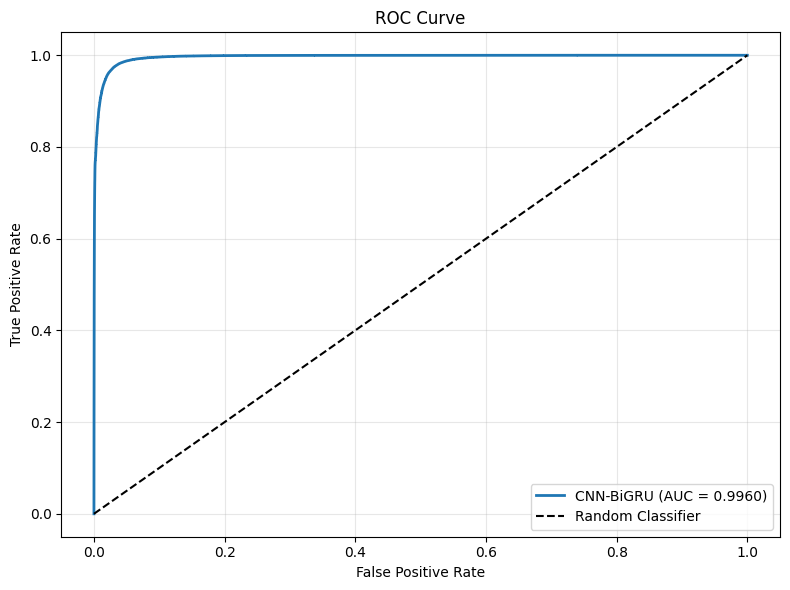

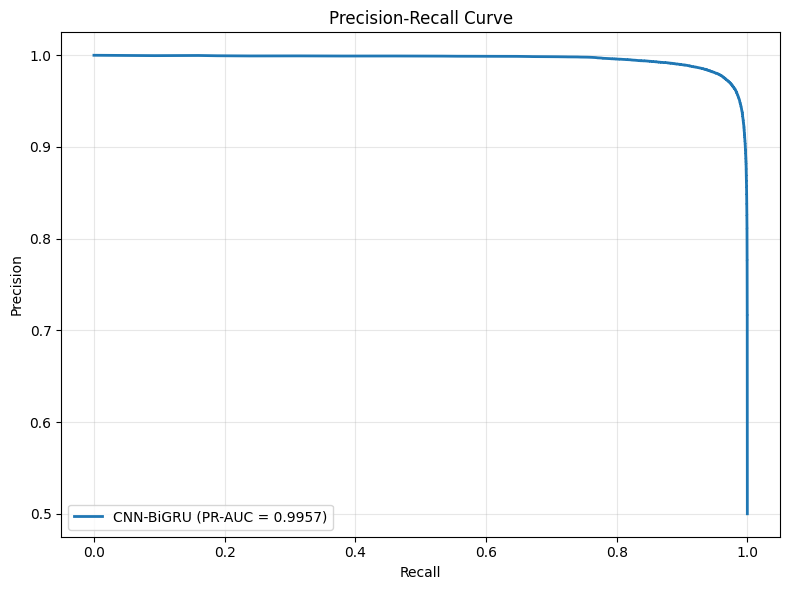

In [13]:
# ========== MODEL 2: CNN-BiGRU ==========
print("\n[6/7] Training Model 2: CNN-BiGRU Hybrid...")
print("-"*80)

# Define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',     # Stop when validation loss stops improving
    patience=3,             # Wait 3 epochs before stopping
    restore_best_weights=True,  # Roll back to best model weights
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,             # Reduce LR by 30%
    patience=2,             # Wait 2 epochs before reducing LR
    verbose=1,
    min_lr=1e-6
)

checkpoint = ModelCheckpoint(
    'model2_best_weights.h5',   # File to save the best weights
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Build model
model2_arch = CNNBiGRUModel(vocab_size, embedding_dim=128, max_len=200)
model2 = model2_arch.build_model()
model2_arch.summary()

# Train model
print("\n🚀 Starting training with Early Stopping and LR Scheduler...")
history2 = model2.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_test, X2_test], y_test),
    epochs=30,
    batch_size=128,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)
print("✓ Model 2 training completed")

# Evaluate
metrics2, y_pred2, y_proba2 = ModelEvaluator.evaluate_model(
    model2, [X1_test, X2_test], y_test, "CNN-BiGRU"
)
results.append(metrics2)

# Visualizations
ModelEvaluator.plot_training_history(history2, "CNN-BiGRU")
ModelEvaluator.plot_confusion_matrix(y_test, y_pred2, "CNN-BiGRU")
ModelEvaluator.plot_roc_curve(y_test, y_proba2, "CNN-BiGRU")
ModelEvaluator.plot_pr_curve(y_test, y_proba2, "CNN-BiGRU")



[7/7] Comparative Analysis

           Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC   PR-AUC
BiLSTM-Attention  0.912886   0.856443 0.99206  0.919276 0.984609 0.983367
       CNN-BiGRU  0.967354   0.948099 0.98884  0.968041 0.996028 0.995689


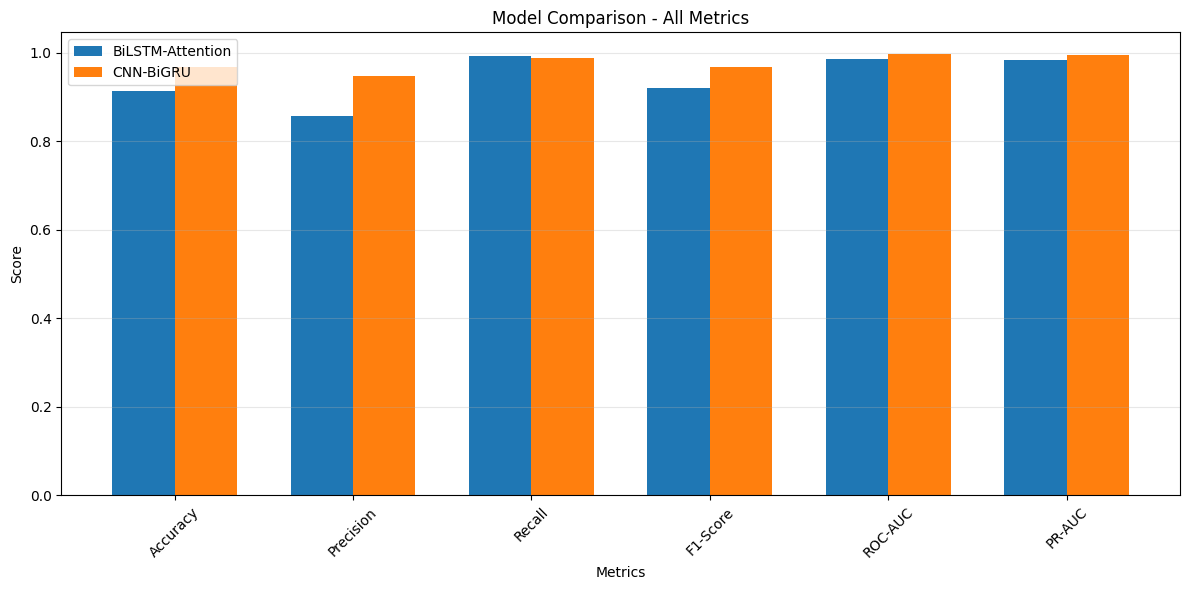


✓ Models saved successfully!

EXECUTION COMPLETED


In [14]:
]=# ========== COMPARATIVE ANALYSIS ==========
print("\n[7/7] Comparative Analysis")
print("="*80)

results_df = pd.DataFrame(results)
print("\n" + results_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.35

ax.bar(x - width/2, results_df.iloc[0][metrics_to_plot], width, label='BiLSTM-Attention')
ax.bar(x + width/2, results_df.iloc[1][metrics_to_plot], width, label='CNN-BiGRU')

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Model Comparison - All Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_plot, rotation=45)
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Save models
model1.save('bilstm_attention_model.h5')
model2.save('cnn_bigru_model.h5')
print("\n✓ Models saved successfully!")

print("\n" + "="*80)
print("EXECUTION COMPLETED")
print("="*80)

testing models

In [ ]:
from tensorflow.keras.models import load_model

# Load saved models
model1 = load_model('/kaggle/working/bilstm_attention_model.h5')
model2 = load_model('/kaggle/working/cnn_bigru_model.h5')

print("✓ Models loaded successfully!")


In [22]:
# Pick 10 random indices from the existing pairs
random_indices = np.random.choice(len(pairs), size=10, replace=False)

sample_pairs = [pairs[i] for i in random_indices]
sample_labels = [labels[i] for i in random_indices]

# Separate clauses
clause1_texts = [p[0] for p in sample_pairs]
clause2_texts = [p[1] for p in sample_pairs]

# Preprocess
clause1_clean = [loader.preprocess_text(t) for t in clause1_texts]
clause2_clean = [loader.preprocess_text(t) for t in clause2_texts]

# Vectorize
X1_test_rand = vectorizer.transform(clause1_clean)
X2_test_rand = vectorizer.transform(clause2_clean)

# Predictions
pred1_probs = model1.predict([X1_test_rand, X2_test_rand])
pred2_probs = model2.predict([X1_test_rand, X2_test_rand])

# Binary labels
pred1_labels = (pred1_probs > 0.5).astype(int)
pred2_labels = (pred2_probs > 0.5).astype(int)

print("\n=== RANDOM TEST PAIRS RESULTS ===")
for i in range(len(sample_pairs)):
    print(f"\nPAIR {i+1}")
    print(f"Clause 1: {clause1_texts[i][:150]}...")
    print(f"Clause 2: {clause2_texts[i][:150]}...")
    print(f"True Label: {'Similar' if sample_labels[i]==1 else 'Dissimilar'}")
    print(f"BiLSTM-Attention → {pred1_probs[i][0]:.4f} ({'Similar' if pred1_labels[i]==1 else 'Dissimilar'})")
    print(f"CNN-BiGRU        → {pred2_probs[i][0]:.4f} ({'Similar' if pred2_labels[i]==1 else 'Dissimilar'})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step

=== RANDOM TEST PAIRS RESULTS ===

PAIR 1
Clause 1: illegality. notwithstanding any other provisions herein, if any present or future law, regulation, treaty or directive or in the interpretation or app...
Clause 2: loans. book value (e) credit card business: book value...
True Label: Dissimilar
BiLSTM-Attention → 0.3742 (Dissimilar)
CNN-BiGRU        → 0.0254 (Dissimilar)

PAIR 2
Clause 1: representations and warranties of seller. seller represents and warrants to buyer as of the date hereof and as of the closing date that the statements...
Clause 2: representations and warranties of seller. except as set forth in the disclosure schedules dated as of the date hereof and delivered herewith to buyer,...
True Label: Similar
BiLSTM-Attention → 1.0000 (Similar)
CNN-BiGRU        → 1.0000 (Similar)

PAIR 3
Clause 1: access. (a) from the date of this agreement until the earlier of the closing or the termination of th